<a href="https://colab.research.google.com/github/sultanbst123/Sports-Image-Classification-/blob/main/Sports_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sport Image 100

In [ ]:
K80 t4

In [ ]:
!nvidia-smi

Thu Jan 27 02:37:44 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load data
Ambil data dari kaggle

In [ ]:
!pip install kaggle

In [ ]:
pip install tensorflow-addons

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random 

#DL library
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# for file
import gdown
import os
from google.colab import files
from zipfile import ZipFile

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [ ]:

# upload kaggle api
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:

# ambil dataset dari kaggle

!kaggle datasets download "gpiosenka/sports-classification" #--unzip

 99% 471M/477M [00:05<00:00, 98.7MB/s]
100% 477M/477M [00:05<00:00, 95.9MB/s]


In [ ]:

# extract ke file food101

with ZipFile("/content/sports-classification.zip", "r") as zipobj:
     zipobj.extractall("sport_images")

In [ ]:
data = pd.read_csv("//content/sport_images/sports.csv")

In [ ]:
train = data[data["data set"] == "train"]
validation = data[data["data set"] == "valid"]
test = data[data["data set"] == "test"]

train.shape, validation.shape, test.shape

((13572, 3), (500, 3), (500, 3))

In [ ]:
train["path"] = "/content/sport_images/" + train["filepaths"]
test["path"] = "/content/sport_images/" + test["filepaths"]
validation["path"] = "/content/sport_images/" + validation["filepaths"]

## Explore

In [ ]:
train.head()

,filepaths,labels,data set,path
0,train/air hockey/001.jpg,air hockey,train,/content/sport_images/train/air hockey/001.jpg
1,train/air hockey/002.jpg,air hockey,train,/content/sport_images/train/air hockey/002.jpg
2,train/air hockey/003.jpg,air hockey,train,/content/sport_images/train/air hockey/003.jpg
3,train/air hockey/004.jpg,air hockey,train,/content/sport_images/train/air hockey/004.jpg
4,train/air hockey/005.jpg,air hockey,train,/content/sport_images/train/air hockey/005.jpg


In [ ]:
# check target 

train.labels.value_counts().to_frame

<bound method Series.to_frame of football              191
formula 1 racing      191
nascar racing         190
baseball              174
hockey                172
                     ... 
horseshoe pitching    102
arm wrestling          99
ultimate               99
wingsuit flying        98
sky surfing            59
Name: labels, Length: 100, dtype: int64>

In [ ]:
# image

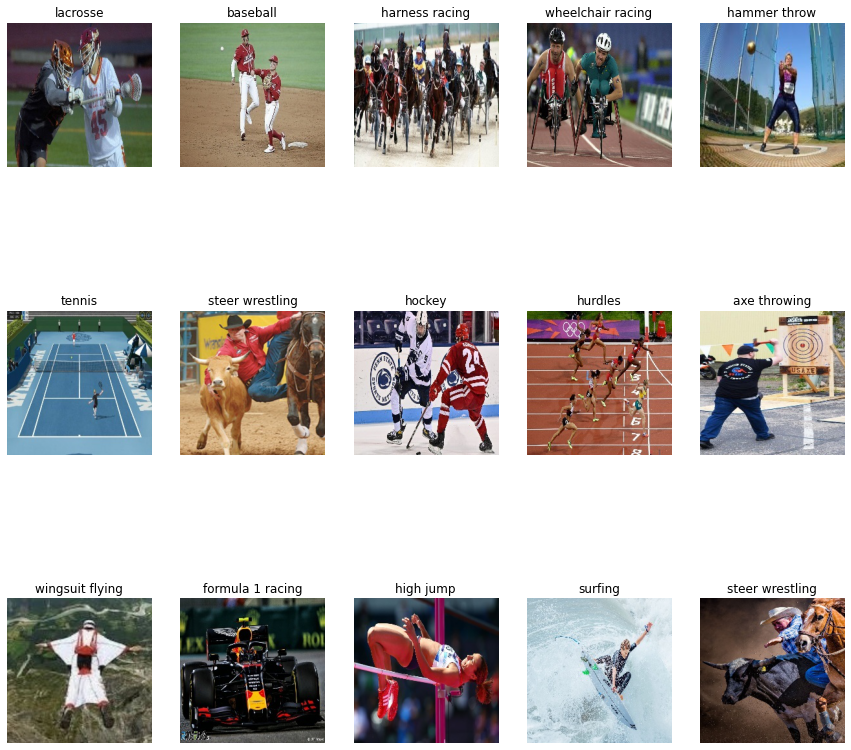

In [ ]:
random_img = np.random.choice(len(train), 15)

plt.figure(figsize=(15, 15))
for i in range(15):
    plt.subplot(3, 5, i+1)
    img = random_img[i]
    my_img = plt.imread(train.path[img]) 
    plt.imshow(my_img) 
    plt.title(train.labels[img])
    plt.axis("off")

## Split

In [ ]:
# ubah ke dari nama label ke diskrit, untuk mengambil nilai asli nya 

LC = LabelEncoder() 
train["new_labels"] = LC.fit_transform(train.labels)
test["new_labels"] = LC.transform(test.labels)
validation["new_labels"] = LC.transform(validation.labels)

In [ ]:

# ambil data train dan validation

x_train, y_train = train.path, tf.keras.utils.to_categorical(train.new_labels)
x_val, y_val = validation.path, tf.keras.utils.to_categorical(validation.new_labels) 

# unseen data 
test_img = test.path

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((13572,), (13572, 100), (500,), (500, 100))

In [ ]:
BATCH_SIZE = 64
AUTO = tf.data.experimental.AUTOTUNE
IMG_SIZE = 224 # resize imahe

In [ ]:
# image test
@tf.function
def get_image(path):
    """Function loads image from a file and preprocesses it.
    :param path: Path to image file
    :return: Tensor with preprocessed image
    """
    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    
    ## Resizing image
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE), dtype=tf.int32)

    return image

# image train & validation
@tf.function
def process_dataset(path, label):

    """Function returns preprocessed image and label.
    :param path: Path to image file
    :param label: Class label
    :return: tf.Tensor with preprocessed image, numeric label
    """
    return get_image(path), label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_ds = train_ds.map(process_dataset, num_parallel_calls=AUTO).shuffle(1000).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_ds = val_ds.map(process_dataset, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((test_img))
test_ds = test_ds.map(get_image, num_parallel_calls=AUTO).batch(BATCH_SIZE)

train_ds, val_ds, test_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 100)), types: (tf.int32, tf.float32)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 100)), types: (tf.int32, tf.float32)>,
 <BatchDataset shapes: (None, 224, 224, 3), types: tf.int32>)

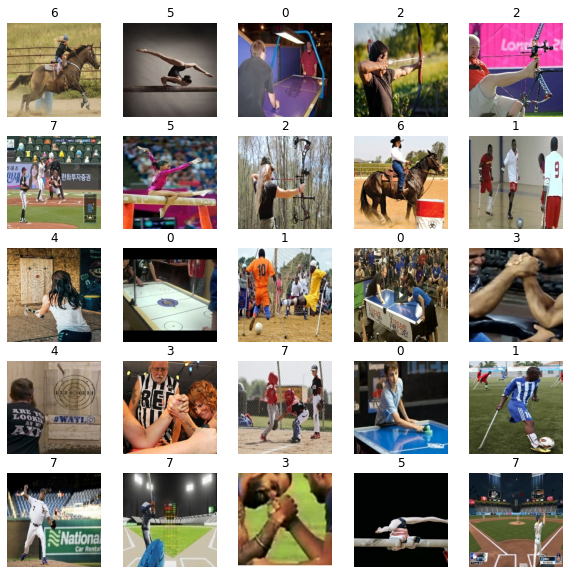

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(np.argmax(label_batch[n].numpy())) 
    plt.axis("off")

## Define Hyper parameters

In [ ]:

# Hyperparamters for fit 

EPOCHS = 40
INIT_LR = 5e-4
MAX_LR = 5e-3
Wd = 1e-4

#define learning rate scheduler
steps_per_epoch =  len(x_train) // BATCH_SIZE

clr = tfa.optimizers.Triangular2CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    step_size= 3 * steps_per_epoch
)

#define optimizers 
SGD = tf.keras.optimizers.SGD(learning_rate=clr, momentum=0.9)
SGDW = tfa.optimizers.SGDW(learning_rate=clr, momentum=0.9, weight_decay = Wd)

ADAM = tf.keras.optimizers.Adam(learning_rate=INIT_LR)
ADABELIEF = tfa.optimizers.AdaBelief(learning_rate = INIT_LR, weight_decay = Wd)
ADAMW = tfa.optimizers.AdamW(learning_rate = INIT_LR, weight_decay = Wd)

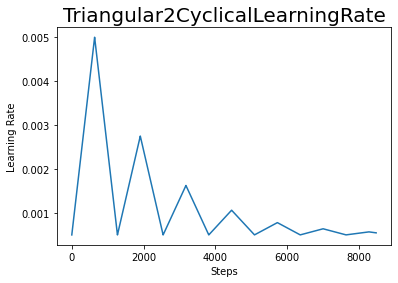

In [ ]:
step = np.arange(0, EPOCHS * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Triangular2CyclicalLearningRate", size=20)
plt.show()

## efficientnet

In [ ]:
pip install -U keras-efficientnet-v2

In [ ]:
import keras_efficientnet_v2

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        #layers.Rescaling(scale=1.0 / 255),#[0, 1]
        #layers.Resizing(224, 224), # resize image 
    
        # sedikit augmentation
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),    
    ],
    name="data_augmentation",
)

In [ ]:
# /// get model ////
input = layers.Input(shape=(224, 224, 3)) 

# geometric transformations augmentation  
x = data_augmentation(input)

# EfficientNetV2B0  model
Eff = keras_efficientnet_v2.EfficientNetV2B0(input_shape=(224,224,3),num_classes = 0,pretrained="imagenet",include_preprocessing = True)(x)

# add fc      
x_fc = layers.GlobalAveragePooling2D()(Eff)
x_fc = layers.LayerNormalization()(x_fc)
output = layers.Dense(100, activation="softmax")(x_fc)

model = tf.keras.Model(inputs=input, outputs=output, name = "ConvNeXtTiny")

# freeze EfficientNetV2B0
for layer in model.layers[2:3]:
    layer.trainable = False

 #compile model 
model.compile(optimizer = ADABELIEF,#SGDW
              loss = tf.keras.losses.CategoricalCrossentropy(),#(label_smoothing=0.1),
              metrics = ["accuracy"]) 

model.summary()

>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-b0-imagenet.h5
Model: "ConvNeXtTiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 EfficientNetV2B0 (Functiona  (None, 7, 7, 1280)       5919312   
 l)                                                              
                                                                 
 global_average_pooling2d_8   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 layer_normalization_59 (Lay

In [ ]:
# save best epoch
checkpoint_filepath = "/tmp/checkpoint"
 
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                 monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(checkpoint_filepath)

Epoch 1/40
213/213 [==============================] - 72s 258ms/step - loss: 4.8260 - accuracy: 0.1146 - val_loss: 2.7220 - val_accuracy: 0.3420
Epoch 2/40
213/213 [==============================] - 47s 216ms/step - loss: 2.1300 - accuracy: 0.4660 - val_loss: 1.5103 - val_accuracy: 0.5560
Epoch 3/40
213/213 [==============================] - 49s 215ms/step - loss: 1.1440 - accuracy: 0.6757 - val_loss: 0.9205 - val_accuracy: 0.7140
Epoch 4/40
213/213 [==============================] - 47s 214ms/step - loss: 0.7576 - accuracy: 0.7807 - val_loss: 0.6443 - val_accuracy: 0.7980
Epoch 5/40
213/213 [==============================] - 47s 212ms/step - loss: 0.5614 - accuracy: 0.8363 - val_loss: 0.4972 - val_accuracy: 0.8320
Epoch 6/40
213/213 [==============================] - 47s 213ms/step - loss: 0.4443 - accuracy: 0.8696 - val_loss: 0.4140 - val_accuracy: 0.8520
Epoch 7/40
213/213 [==============================] - 47s 213ms/step - loss: 0.3624 - accuracy: 0.8956 - val_loss: 0.3580 - val_ac

In [ ]:
loss, accuracy, = model.evaluate(val_ds)
print(f"Val loss: {round(loss, 2)}")
print(f"Val accuracy: {round(accuracy * 100, 2)}%")

8/8 [==============================] - 2s 184ms/step - loss: 0.0993 - accuracy: 0.9700
Val loss: 0.1
Val accuracy: 97.0%


In [ ]:
predict = model.predict(test_ds)

In [ ]:
print(f"accuracy score test datasets: {accuracy_score(test.labels,LC.inverse_transform(np.argmax(predict, axis=1)))}% ")

accuracy score test datasets: 0.96% 


In [ ]:

#save model

model.save("best_sport.h5")

In [ ]:
# simpan ke file drive
!cp "/content/best_sport.h5" "/content/drive/MyDrive/swintransformertf"

## Mobile-Vit v2

In [ ]:
# referensj 

#https://github.com/avinash31d/paper-implementations

In [ ]:
patch_size = 4 
image_size = 256
image_size_large = 270
expansion_ratio = 2.0
num_classes = 100

In [ ]:
class InvertedRes(layers.Layer):
  def __init__(self, expand_channels, output_channels, strides=1):
    super().__init__()
    self.output_channels = output_channels
    self.strides = strides
    self.expand = tf.keras.models.Sequential([
                                          layers.Conv2D(expand_channels, 1, padding="same", use_bias=False),
                                          layers.BatchNormalization(),
                                          layers.Activation('swish')
                                        ], name="expand")
    self.dw_conv = tf.keras.models.Sequential([
                                          layers.DepthwiseConv2D(3, strides=strides, padding="same", use_bias=False),
                                          layers.BatchNormalization(),
                                          layers.Activation('swish')
                                        ], name="depthwise")
    self.pw_conv = tf.keras.models.Sequential([
                                          layers.Conv2D(output_channels, 1, padding="same", use_bias=False),
                                          layers.BatchNormalization(),
                                        ], name='pointwise')
  
  def call(self, x):
    o = self.expand(x)
    o = self.dw_conv(o)
    o = self.pw_conv(o)
    if self.strides == 1 and o.shape[-1] == self.output_channels:
      return o + x
    return o

In [ ]:
class FullyConnected(layers.Layer):
  def __init__(self, hidden_units, dropout_rate):
    super().__init__()
    l = []
    for units in hidden_units:
      l.append(layers.Dense(units, activation=tf.nn.swish))
      l.append(layers.Dropout(dropout_rate))
    self.mlp = tf.keras.models.Sequential(l)

  def call(self, x):
    return self.mlp(x)

In [ ]:
class Transformer(layers.Layer):
  def __init__(self, projection_dim, heads=2):
    super().__init__()
    self.norm1 = layers.LayerNormalization(epsilon=1e-6)
    self.attention = layers.MultiHeadAttention(num_heads=heads, key_dim=projection_dim, dropout=0.1)
    self.norm2 = layers.LayerNormalization(epsilon=1e-6)
  
  def build(self, input_shape):
    self.mlp = FullyConnected([input_shape[-1] * 2, input_shape[-1]], dropout_rate=0.1)


  def call(self, x):
    x1 = self.norm1(x)
    att = self.attention(x1, x1)
    x2 = x + att
    x3 = self.norm2(x2)
    x3 = self.mlp(x3)
    return x3 + x2

In [ ]:
class MobileVitBlock(layers.Layer):
  def __init__(self, num_blocks, projection_dim, strides=1):
    super().__init__()
    self.projection_dim = projection_dim
    self.conv_local = tf.keras.models.Sequential([
                                           layers.Conv2D(projection_dim, 3, padding="same", strides=strides, activation=tf.nn.swish),
                                           layers.Conv2D(projection_dim, 1, padding="same", strides=strides, activation=tf.nn.swish),
                                           ])
    self.transformers = tf.keras.models.Sequential([Transformer(projection_dim, heads=2) for i in range(num_blocks)])
    self.conv_folded = layers.Conv2D(projection_dim, 1, padding="same", strides=strides, activation=tf.nn.swish)
    self.conv_local_global = layers.Conv2D(projection_dim, 3, padding="same", strides=strides, activation=tf.nn.swish)

  def build(self, input_shape):
    num_patches = int((input_shape[1] * input_shape[2]) / patch_size)
    self.unfold = layers.Reshape((patch_size, num_patches, self.projection_dim))
    self.fold = layers.Reshape((input_shape[1], input_shape[2], self.projection_dim))

  def call(self, x):
    local_features = self.conv_local(x)
    patches = self.unfold(local_features)
    global_features = self.transformers(patches)
    folded_features = self.fold(global_features)
    folded_features = self.conv_folded(folded_features)
    local_global_features = tf.concat([x, folded_features], axis=-1)
    local_global_features = self.conv_local_global(local_global_features)
    return local_global_features

In [ ]:
class MobileVit(tf.keras.models.Model):
  def __init__(self, num_classes=num_classes):
    super().__init__()
    self.features = tf.keras.models.Sequential([ layers.Rescaling(scale=1.0 / 255),
                                              layers.Conv2D(16, 3, padding="same", strides=(2, 2), activation=tf.nn.swish),
                                              InvertedRes(16 * expansion_ratio, 16, strides=1),
                                              InvertedRes(16 * expansion_ratio, 24, strides=2),
                                              InvertedRes(24 * expansion_ratio, 24, strides=1),
                                              InvertedRes(24 * expansion_ratio, 24, strides=1),
                                              InvertedRes(24 * expansion_ratio, 48, strides=2),
                                              MobileVitBlock(2, 64, strides=1),
                                              InvertedRes(64 * expansion_ratio, 64, strides=2),
                                              MobileVitBlock(4, 80, strides=1),
                                              InvertedRes(80 * expansion_ratio, 80, strides=2),
                                              MobileVitBlock(3, 96, strides=1),
                                              layers.Conv2D(320, 1, padding="same", strides=(1, 1), activation=tf.nn.swish)
                                            ], name = "features")
    
    self.head = tf.keras.models.Sequential([layers.GlobalAvgPool2D(),
                                         layers.Dense(num_classes, activation="softmax")
                                         ], name="logits")
    
  def call(self, x):
    features = self.features(x)
    logits = self.head(features)
    return logits

In [ ]:
model = MobileVit()

In [ ]:
model.build((None, 256, 256, 3))
model.summary()

Model: "mobile_vit_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (Sequential)       (None, 8, 8, 320)         1344464   
                                                                 
 logits (Sequential)         (None, 100)               32100     
                                                                 
Total params: 1,376,564
Trainable params: 1,374,020
Non-trainable params: 2,544
_________________________________________________________________


In [ ]:
model.compile(optimizer = ADABELIEF, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics = ["accuracy"])

model.summary()

Model: "mobile_vit_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 features (Sequential)       (None, 8, 8, 320)         1344464   
                                                                 
 logits (Sequential)         (None, 100)               32100     
                                                                 
Total params: 1,376,564
Trainable params: 1,374,020
Non-trainable params: 2,544
_________________________________________________________________


In [ ]:
checkpoint_filepath = "/tmp/checkpoint"
 
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, 
                                 monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(checkpoint_filepath)

In [ ]:
# accuracy yang lumayan buruk